In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from scipy import stats
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [3]:
df = pd.read_csv('tlc_trips_2015_1.csv')
df.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount
count,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000
mean,1.529280,1.728846,33.254124,-72.439096,39.904999,1.040236,-72.466753,39.921661,1.443663,12.311465,0.317807,0.497320,1.429117,0.249592,15.103474
std,0.499142,1.350778,16450.044341,10.543581,5.808402,0.571249,10.446317,5.754597,0.510300,10.498447,0.346093,0.038653,2.637536,1.316707,12.638301
min,1.000000,0.000000,0.000000,-108.165337,0.000000,1.000000,-79.181625,-9.029157,1.000000,-100.000000,-79.000000,-0.500000,-92.420000,0.000000,-100.300000
25%,1.000000,1.000000,1.010000,-73.991379,40.733849,1.000000,-73.990875,40.732353,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,8.150000
50%,2.000000,1.000000,1.800000,-73.981293,40.752304,1.000000,-73.979050,40.752617,1.000000,9.000000,0.500000,0.500000,1.000000,0.000000,11.300000
75%,2.000000,2.000000,3.330000,-73.965492,40.767212,1.000000,-73.959808,40.768620,2.000000,14.000000,0.500000,0.500000,2.000000,0.000000,16.800000
max,2.000000,9.000000,11800000.400000,0.000000,55.708855,99.000000,85.274025,55.708855,4.000000,965.000000,9.000000,0.500000,850.000000,305.410000,1574.300000


In [4]:
# NYC boundries: http://www.nyc.gov/html/dcp/pdf/bytes/nybb_metadata.pdf?v=15d
mask1 = ~((df['trip_distance']>40)&(df['total_amount']<40))
mask2 = ~((df['trip_distance']<10)&(df['fare_amount']>200))
df = df[(df['total_amount']>0) & (df['tip_amount']>=0) & (df['pickup_longitude']<-73.699215) & (df['pickup_longitude']>-74.257159) & 
        (df['pickup_latitude']<40.915568) & (df['pickup_latitude']>40.495992) & (df['dropoff_longitude']<-73.699215) &
        (df['dropoff_longitude']>-74.257159) & (df['dropoff_latitude']<40.915568) & (df['dropoff_latitude']>40.495992) &
        (df['trip_distance']>0) & (df['trip_distance']<100) & (df['fare_amount']>0) & mask1 & mask2]
df['amount'] = df['total_amount']-df['tip_amount']
df = df.drop(['fare_amount','extra','mta_tax','tolls_amount','total_amount',
              'VendorID','passenger_count','RateCodeID','store_and_fwd_flag','payment_type'],axis=1)
df.describe()

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,amount
count,972382.000000,972382.000000,972382.000000,972382.000000,972382.000000,972382.000000,972382.000000
mean,2.988344,-73.973860,40.750418,-73.972657,40.751044,1.416085,13.587292
std,3.475066,0.036042,0.028465,0.035196,0.033083,2.187212,10.614983
min,0.010000,-74.255371,40.572315,-74.255379,40.505913,0.000000,0.310000
25%,1.040000,-73.991547,40.735348,-73.991066,40.733971,0.000000,7.300000
50%,1.800000,-73.981705,40.753014,-73.979538,40.753452,1.000000,10.300000
75%,3.360000,-73.967041,40.767693,-73.961624,40.769119,2.000000,15.300000
max,63.900000,-73.703415,40.914936,-73.699242,40.915146,212.110000,337.210000


In [5]:
df = df.reindex(np.random.permutation(df.index))
df = df[0:100000]
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,amount
210081,2015-01-09 08:51:18,2015-01-09 08:54:31,0.50,-74.002991,40.744804,-74.007835,40.739471,0,4.80
144209,2015-01-09 06:47:52,2015-01-09 08:09:33,17.87,-73.782379,40.644688,-73.986183,40.730389,0,58.13
794857,2015-01-02 02:17:42,2015-01-02 02:23:03,0.66,-74.000580,40.729763,-74.002342,40.733551,0,6.80
30461,2015-01-08 23:26:35,2015-01-08 23:34:46,2.21,-73.970001,40.789776,-73.955032,40.815113,0,10.30
945925,2015-01-09 23:52:33,2015-01-10 00:15:20,4.80,-73.983849,40.725521,-73.984711,40.671192,0,21.30


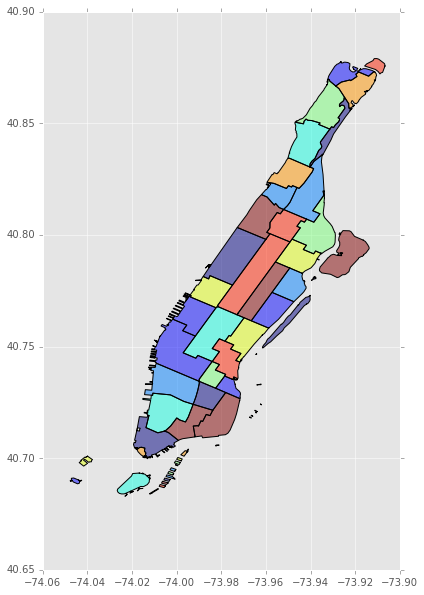

In [6]:
gdf = gpd.read_file('nyc-neighborhoods.geojson')
gdf = gdf.drop('@id',axis=1)
gdf = gdf[gdf.BoroName=='Manhattan']
gdf.plot(figsize=(20,10))

In [7]:
df_net = pd.DataFrame(columns=['a','b','w'])
gdf_trip = gdf[gdf.NTAName!='park-cemetery-etc-Manhattan']
count = 0
for i in gdf.NTAName.unique():
    for j in gdf_trip.NTAName.unique():
        df_net.loc[count] = [i,j,0]
        count += 1

In [8]:
count = 0
for i in df.index:
    try:
        df.loc[i,'pickup_nta'] = gdf_trip[gdf_trip.geometry.contains(Point(df.pickup_longitude[i],df.pickup_latitude[i]))].NTAName.values[0]
        df.loc[i,'dropoff_nta'] = gdf_trip[gdf_trip.geometry.contains(Point(df.dropoff_longitude[i],df.dropoff_latitude[i]))].NTAName.values[0]
    except:
        continue
    count += 1
df.head(100)

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,amount,pickup_nta,dropoff_nta
210081,2015-01-09 08:51:18,2015-01-09 08:54:31,0.50,-74.002991,40.744804,-74.007835,40.739471,0.00,4.80,Hudson Yards-Chelsea-Flatiron-Union Square,West Village
144209,2015-01-09 06:47:52,2015-01-09 08:09:33,17.87,-73.782379,40.644688,-73.986183,40.730389,0.00,58.13,NaN,NaN
794857,2015-01-02 02:17:42,2015-01-02 02:23:03,0.66,-74.000580,40.729763,-74.002342,40.733551,0.00,6.80,West Village,West Village
30461,2015-01-08 23:26:35,2015-01-08 23:34:46,2.21,-73.970001,40.789776,-73.955032,40.815113,0.00,10.30,Upper West Side,Manhattanville
945925,2015-01-09 23:52:33,2015-01-10 00:15:20,4.80,-73.983849,40.725521,-73.984711,40.671192,0.00,21.30,East Village,NaN
286318,2015-01-01 06:12:10,2015-01-01 06:23:12,2.99,-73.978996,40.728127,-73.964630,40.712517,0.00,12.80,East Village,NaN
462207,2015-01-01 14:27:37,2015-01-01 15:00:21,18.51,-73.790161,40.644485,-73.981133,40.760761,0.00,58.13,NaN,NaN
387910,2015-01-09 13:08:44,2015-01-09 13:24:17,1.69,-73.977829,40.764412,-73.990082,40.751740,0.00,11.80,Midtown-Midtown South,Midtown-Midtown South
566076,2015-01-01 17:30:21,2015-01-01 17:55:21,10.80,-73.863853,40.769928,-73.998299,40.732056,0.00,33.30,NaN,NaN
577322,2015-01-09 17:50:16,2015-01-09 17:55:36,1.43,-73.965553,40.762943,-73.951416,40.777721,0.00,8.30,Lenox Hill-Roosevelt Island,Yorkville


In [30]:
df = df.dropna(subset=['pickup_nta','dropoff_nta'])
df_tip = df[['pickup_nta','dropoff_nta','tip_amount','amount']].copy()
edges = df_tip.groupby(['pickup_nta','dropoff_nta'],as_index=False).aggregate(np.sum)

In [31]:
for i in df_net.index:
    mask = (edges.pickup_nta==df_net.loc[i,'a'])&(edges.dropoff_nta==df_net.loc[i,'b'])
    try:
        df_net.loc[i,'w'] = edges[mask].tip_amount.values[0]/edges[mask].amount.values[0]
    except:
        df_net.loc[i,'w'] = np.nan
df_net = df_net.dropna()
df_net

,a,b,w
0,East Village,East Village,0.092734
1,East Village,Clinton,0.116894
2,East Village,Manhattanville,0.000000
3,East Village,Washington Heights South,0.106754
4,East Village,Gramercy,0.124619
5,East Village,Lincoln Square,0.105752
6,East Village,Hamilton Heights,0.116000
7,East Village,Central Harlem South,0.105630
8,East Village,Chinatown,0.108254
9,East Village,Stuyvesant Town-Cooper Village,0.126829


In [32]:
trips = nx.DiGraph()
nx.set_edge_attributes(trips, 'weight', 0)
for k in df_net.index:
    trips.add_edge(df_net.a[k],df_net.b[k],weight=df_net.w[k])

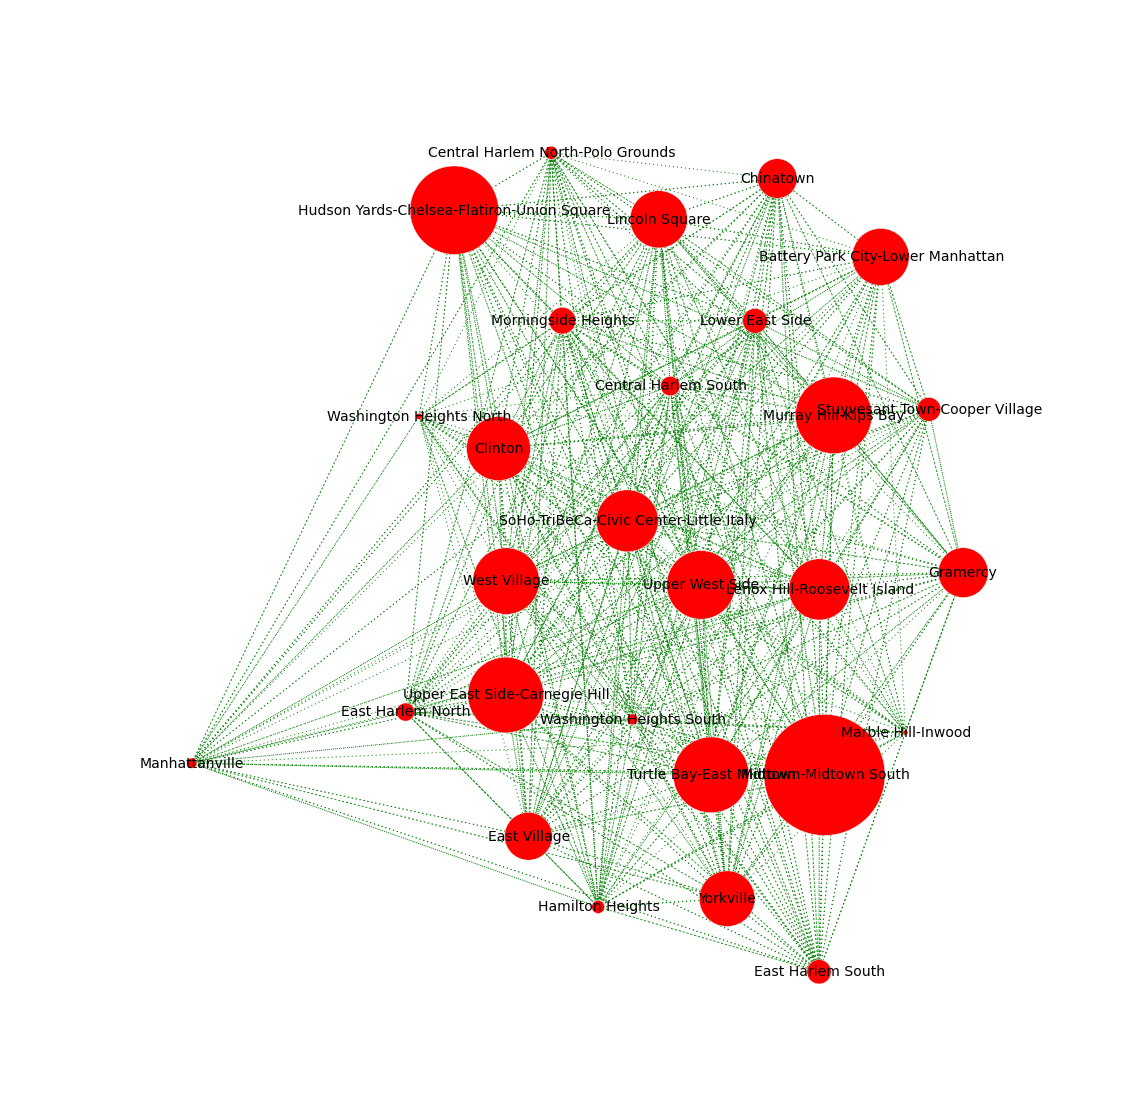

In [33]:
pnodes = df_tip[['pickup_nta','amount']].groupby(['pickup_nta'],as_index=False).aggregate(np.count_nonzero)
pnodes_dict = {}
for n in trips.nodes():
    pnodes_dict[n] = pnodes[pnodes.pickup_nta==n].amount.values[0]
plt.figure(figsize = (15,15))
nx.draw(trips,pos=nx.spring_layout(trips),node_size=np.array(pnodes_dict.values()),arrows=False,with_labels=True,style='dotted',edge_color='green',font_size=14)

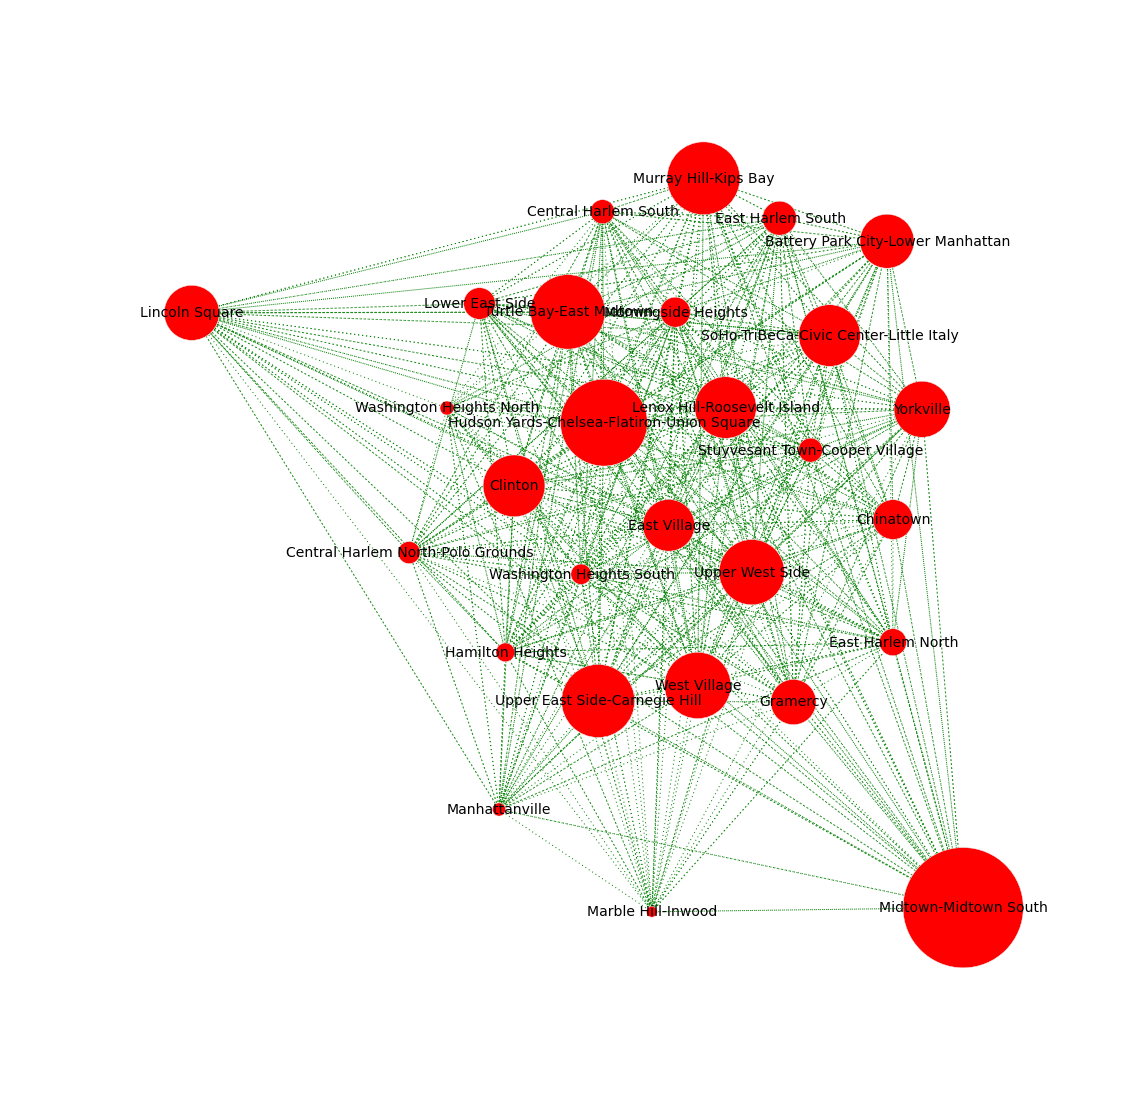

In [34]:
dnodes = df_tip[['dropoff_nta','amount']].groupby(['dropoff_nta'],as_index=False).aggregate(np.count_nonzero)
dnodes_dict = {}
for n in trips.nodes():
    dnodes_dict[n] = dnodes[dnodes.dropoff_nta==n].amount.values[0]
plt.figure(figsize = (15,15))
nx.draw(trips,pos=nx.spring_layout(trips),node_size=np.array(dnodes_dict.values()),arrows=False,with_labels=True,style='dotted',edge_color='green',font_size=14)

In [35]:
corr=stats.pearsonr(pnodes_dict.values(),dnodes_dict.values())[0]
print('Correlation bewteen pickups and dropoffs: {0}'.format(corr))

Correlation bewteen pickups and dropoffs: 0.996962307773


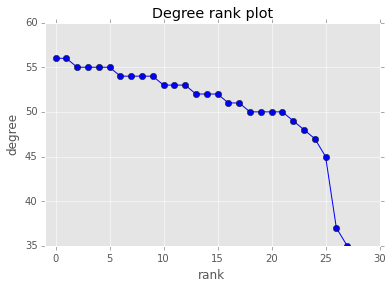

In [36]:
degree_sequence=sorted(nx.degree(trips).values(),reverse=True)
plt.xlim([-1,30])
plt.plot(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

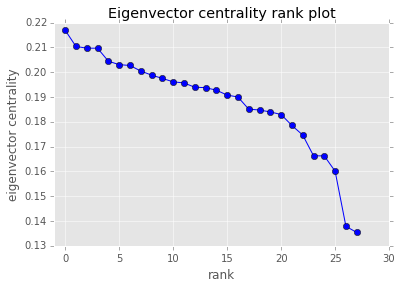

In [37]:
eigen_sequence=sorted(nx.eigenvector_centrality(trips).values(),reverse=True)
plt.xlim([-1,30])
plt.plot(eigen_sequence,'b-',marker='o')
plt.title("Eigenvector centrality rank plot")
plt.ylabel("eigenvector centrality")
plt.xlabel("rank")
plt.show()

In [38]:
eigen_dict = nx.eigenvector_centrality(trips)
count = 0
eigen_list = []
print 'Top 5 important nodes according to eigenvector centrality:'
for t in eigen_sequence[:5]:
    for i, j in eigen_dict.iteritems():
        if j==t:
            print i, j
            eigen_list.append(i)
    count += 1

Top 5 important nodes according to eigenvector centrality:
Hudson Yards-Chelsea-Flatiron-Union Square 0.21695515045
West Village 0.210398608425
Upper West Side 0.209688753146
Lenox Hill-Roosevelt Island 0.209681458714
Morningside Heights 0.204454231285


In [39]:
edges = []
for i in range(len(trips.edges(data=True))):
    edges.append(trips.edges(data=True)[i][2]['weight'])
edges = sorted(edges,reverse=True)

In [40]:
edges[:5]
route_dict = {}
print 'Top 5 routes based on tipping percentage:'
for t in edges[:5]:
    for i in range(len(trips.edges(data=True))):
        if trips.edges(data=True)[i][2]['weight']==t:
            print '%s - %s: %.3f' % (trips.edges(data=True)[i][0], trips.edges(data=True)[i][1], t)
            if trips.edges(data=True)[i][0] in route_dict:
                pass
            else:
                route_dict[trips.edges(data=True)[i][0]] = trips.edges(data=True)[i][1]

Top 5 routes based on tipping percentage:
Stuyvesant Town-Cooper Village - Washington Heights South: 0.250
Washington Heights South - SoHo-TriBeCa-Civic Center-Little Italy: 0.250
Stuyvesant Town-Cooper Village - Washington Heights South: 0.250
Washington Heights South - SoHo-TriBeCa-Civic Center-Little Italy: 0.250
Central Harlem North-Polo Grounds - Lower East Side: 0.250
Manhattanville - Upper East Side-Carnegie Hill: 0.233
Hamilton Heights - Midtown-Midtown South: 0.221


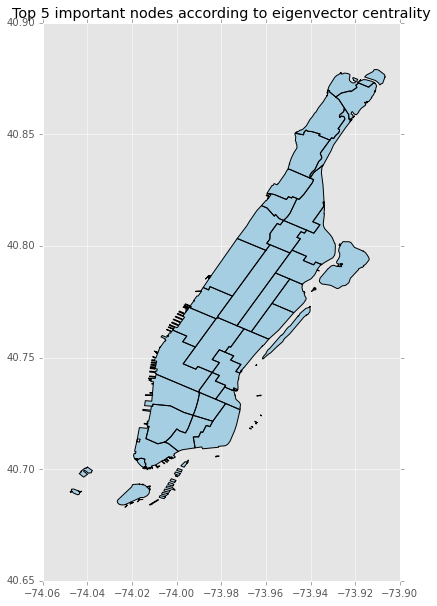

In [41]:
for e in eigen_list:
    for i in gdf.index:
        if gdf.loc[i,'NTAName']==e:
            gdf.loc[i,'eigen_cent']=1
gdf.plot(column='eigen_cent', alpha=1.0, colormap='Paired', figsize=(20,10))
plt.title('Top 5 important nodes according to eigenvector centrality')

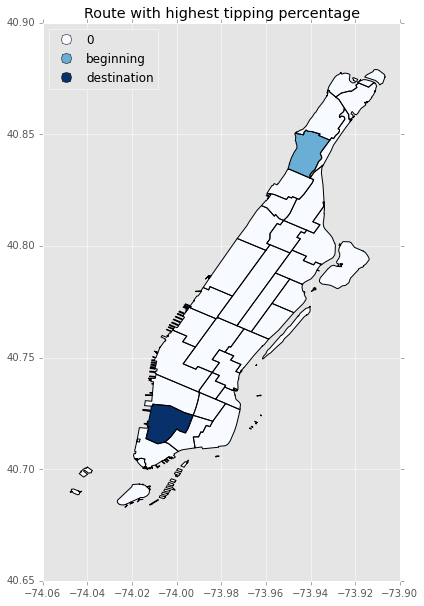

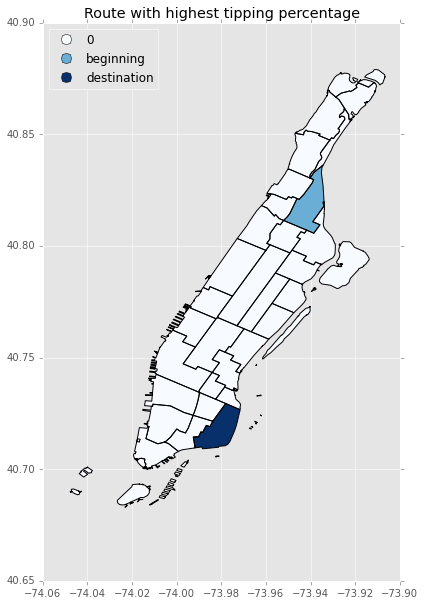

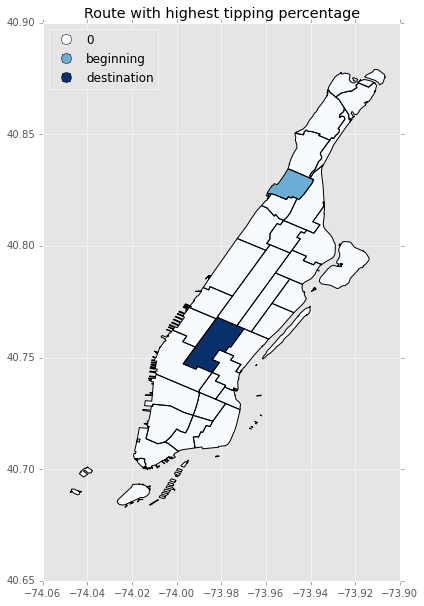

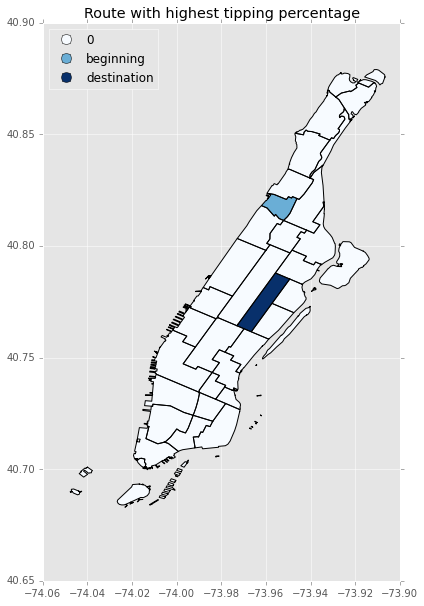

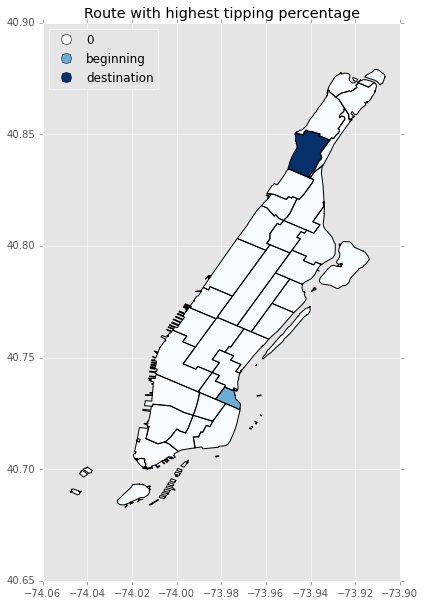

In [23]:
for k in route_dict:
    plt.figure()
    gdf['route']=0
    for i in gdf.index:
        if gdf.loc[i,'NTAName']==k:
            gdf.loc[i,'route'] = 'beginning'
        elif gdf.loc[i,'NTAName']==route_dict[k]:
            gdf.loc[i,'route'] = 'destination'
    try:
        gdf.plot(column='route', alpha=1.0, categorical=True, legend=True, colormap='Blues', figsize=(20,10))
    except:
        pass
    plt.title('Route with highest tipping percentage')

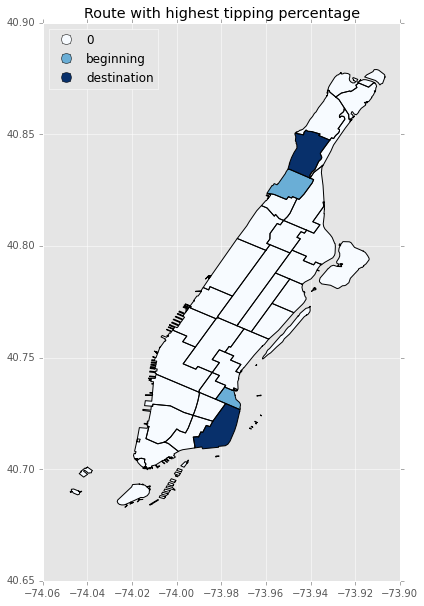

In [24]:
for i in gdf.index:
    if gdf.loc[i,'NTAName']=='Hamilton Heights':
        gdf.loc[i,'route'] = 'beginning'
    elif gdf.loc[i,'NTAName']=='Lower East Side':
        gdf.loc[i,'route'] = 'destination'
gdf.plot(column='route', alpha=1.0, categorical=True, legend=True, colormap='Blues', figsize=(20,10))
plt.title('Route with highest tipping percentage')